# Introduction
I tried one approach based on making "decisions" on the last FC layer of classifier, the method details will be expalined later. That method failed, even that the baseline model made a good separation between the classes, see the details and TSNE figure later.

I took other approach based on multi task auto encoder. This method worked very well, the details will be expalined later.

**Note:**

**Each of my models had two phases:** 

First training a baseline model.

The second phase took the baseline model and made "clever" inference on the model behavior. Then added some adaptations such that the baseline model stands alone and can predict the close set problem of MNIST. And, the baseline model + adaptations provide a new model that predicts the Open Set problem. 

# Setup

Trust me, I need this package. It can be installed only if Cython already installed on the local machine

In [ ]:
%pip install Cython && pip install libmr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn
import torchvision.datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch import nn, optim
from torchsummary import summary
import libmr
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from matplotlib.patches import Polygon
from numpy import reshape
import seaborn as sns
import pandas as pd 
from google.colab import files
import pickle
import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
# if cpu available, use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")

# Data preparation


## Prepare trainset, validation set and testset

In [ ]:
# transform each image to tensor
mnist_dataset_train = torchvision.datasets.MNIST('./mnist/train', download=True,  train=True, transform=ToTensor())
mnist_dataset_test = torchvision.datasets.MNIST('./mnist/test', download=True,  train=False, transform=ToTensor())
# calculate validation set and train set size by 20% and 80%
validation_portion = 0.2
dataset_size = len(mnist_dataset_train)
validation_size = int(validation_portion * dataset_size)
train_size = dataset_size - validation_size

# make split over train set by 80% 20%
trainset_subset, validationset_subest = torch.utils.data.random_split(mnist_dataset_train, [train_size, validation_size])
# prepare dataloaders
trainset = torch.utils.data.DataLoader(trainset_subset, batch_size=64, shuffle=False, num_workers=4) 
validationset = torch.utils.data.DataLoader(validationset_subest, batch_size=64, shuffle=False, num_workers=4)
testset = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Data preprocessing

For data normalization we need to calculate the mean and std of the train set. 

Then apply the normalization on train, validation and test sets during training and evaluation.

In [ ]:
# compute mean and std from dataloader
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std
train_mean, train_std = get_mean_and_std(trainset)
# Since MNIST is dataset of images of 1 channel * 28 width * 28 Hight 
# We calculate mean and std on one channel
train_mean, train_std

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(tensor([0.1307]), tensor([0.3081]))

In [ ]:
# apply preprocessing over dataset of tensors
preprocessing = torchvision.transforms.Compose([
  torchvision.transforms.Normalize(train_mean, train_std),
  torchvision.transforms.Resize((28,28))
])

## OOD Data preparation and preprocessing

In [ ]:
# Dataset class needed for creating custom random subset of CIFAR 10
class OODCifar10(Dataset):
    # OOD distribution label is 10, when MNIST labels are running from 0 to 9
    OOD_LABEL = 10
    # get size of desired subset
    def __init__(self, size, transform=None):
        self.cifar_10 = torchvision.datasets.CIFAR10('./cifar-10', download=True, train=True, transform=transform)
        # shuffle CIFAR 10
        permutation = torch.randperm(len(self.cifar_10))
        # Take the first N desired samples indexes
        self.indeces_in_subset = permutation[:size]

    def __len__(self):
        return self.indeces_in_subset.size()[0]

    def __getitem__(self, idx):
        if not torch.is_tensor(idx):
            idx = torch.tensor(idx)
        # map from index to CIFAR index
        # e.g. you want to get the 100th sample then it's index in CIFAR may be 1674
        cifar_indices = self.indeces_in_subset.index_select(0, idx)
        samples = []
        labels = []
        for i in cifar_indices:
            sample, _ = self.cifar_10[i]
            samples.append(sample)
            # label each sample as 'Unkown'
            labels.append(OODCifar10.OOD_LABEL)
        if len(labels) == 1:
          return sample, labels[0]
        else:
          return sample, np.array(labels)

In [ ]:
cifar_preprocessing = torchvision.transforms.Compose([
    # CIFAR is dataset of RGB images, convert them to Grayscale because MNIST is grayscale
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(), 
    # Apply normalization per pixel before resizing, 
    # because we may loose information if we resize and the normalize.
    # because resize uses bilinear interpolation at the backend
    torchvision.transforms.Normalize(train_mean, train_std),
    torchvision.transforms.Resize((28,28))
])
ood_dataset = OODCifar10(1000, cifar_preprocessing)
# creat data loader that doesn't shuffle, the dataset. Because we already shuffled it in __init__
ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=4, shuffle=False, num_workers=4) 

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize some samples from CIFAR 10

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


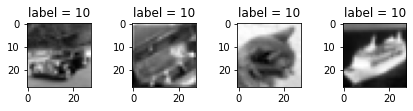

In [ ]:
def imshow(fig, inp, title=None, grayscale=False):
    """Imshow for Tensor."""
    if inp.size()[0] == 1:
      inp = inp.squeeze(dim=0)
    else:
      inp = inp.numpy().transpose((1, 2, 0))
    if title is not None:
      # title is tensor of number
      fig.title.set_text(f'label = {title.item()}')
    if grayscale:
      fig.imshow(inp, cmap='gray')
    else:
      fig.imshow(inp)

def show_single_image(img, grayscale=False):
    f, axarr = plt.subplots(1, 1, figsize=(6,6))
    imshow(axarr, img, grayscale=grayscale)
    plt.show()

def show_sample_from_data_loader(loader, grayscale=False):
    # Get a batch of training data
    inputs, classes = next(iter(ood_loader))
    inputs = inputs[:8]
    classes = classes[:8]
    f, axarr = plt.subplots(1, len(inputs), figsize=(6,6))
    # make more space between plots
    f.tight_layout()
    for index, image in enumerate(inputs):
        imshow(axarr[index], inputs[index], title=classes[index], grayscale=grayscale)  
    plt.show()

show_sample_from_data_loader(ood_loader, grayscale=True)

# Generic helper functions

In [ ]:
def train_model(model, trainloader, trainset_size, validationloader, validationset_size, \
                optimizer, device=None, epochs_amount = 1):
    metrics = {
        'epochs': [],
        'loss': {
            'train': [],
            'validation': [],
        },
        'accuracy': {
            'train': [],
            'validation': [],
        }
    }
    if device is not None:
        model = model.to(device)
    print('Training the model')
    for epoch in  tqdm(range(epochs_amount)):
        for stage in ['train', 'validation']:
            model.epoch_train(optimizer, trainloader, validationloader, \
                stage, metrics, trainset_size, validationset_size, device)
        metrics['epochs'].append(epoch)
    print('Finished Training')
    if device is not None:
        model = model.to(device_cpu)
    return metrics

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="orange" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="orange" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Open Max approach

### Approach Description

My approach was inspired by these papers.

OpenMax:

* Paper:
  * https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Bendale_Towards_Open_Set_CVPR_2016_paper.html

* Src Code:
  * https://github.com/abhijitbendale/OSDN

Open CNN:
* https://www.sciencedirect.com/science/article/pii/S1877050920316240

The first paper (OpenMax) suggests an algorithm for open set recognition using a pre-trained model (the authors used Alex-net in the paper). 

The algorithm uses a fixed pre-trained model and works in the following way:

1. Takes the all samples (from train set) that were correctly classified by the pre-trained model and then feeds them to get activation vectors - the result vector of the last Fully connected layer, of just simply *av*. In code: ``get_corrected_labeled_samples``.
2. Given for each *av* we know from which sample it came thus we know it's label. For each label we calculate the mean activation vector over all labels's *av*-s, we will call it simply *mav*.
3. For each label, we calculate distances between label's *av*-s and label's *mav*. And take the most $\eta$ far distances. In code: In class ``OpenCNN`` method ``train_dataset_mav`` and **global** method ``fit_osr``.
4. Given these distances we fit a [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) for each label. 
Couple words about this distribution.
It comes from Extreme Value Theory, a sub domain in statistics that gives alot of "penalty" to events that are so called "low frequency high sevirity". **Intuitively I used this method because I wanted to be sensetive to exterme distances, thus to mark the sample as *Unknown***.
The authors used a python package ``libmr`` for fitting this distribution on the distances.
I use it in same manner as the authors did at their [src code](https://github.com/abhijitbendale/OSDN).

Now during inference - to give vector of 11 probabilities (10 for MNIST and 1 for OOD). 
1.  Feeding an image to pre-trained model. To get *av* of length 10.
2. After appling log softmax to *av*, we take the $\alpha$ labels that gave the higest probability.
3. Assign $\alpha$ weights to each label, when the most significant get the highest. In code: In class ``OpenCNN`` method ``prepare_alpha_score_per_class``.
4. For each label in MNIST, we compute the distance from the *av* to *mav* then calculating the probability according to [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution). In code: In class ``OpenCNN`` method ``compute_w_scores``.
5. Rearrange new vector of length 11 that takes into considerataion the ``alpha_scores`` and ``w_scores``(probabilities).

6. Apply log softmax on the new vector.


The second paper suggests a CNN based Deep neural network that uses Open Max for Open Set Recognition on intrusion detection. The authors transfered packets to matrices and then feeded the CNN. They called it Open CNN.

I used Open CNN architechture and Open Max for MNIST Open Set Recognition.

The method has two parts, training a Baseline model then applying Open Max algorithm on the last FC layer.
The base line model is:
1. CNN layer with kernel size 5 and 32 output channels.
2. Max pooling layer with kernel size 2. 
3. CNN layer with kernel size 3 and 64 output channels.
4. Max pooling layer with kernel size 2.
5. FC layer of 10 neurons followed by Relu and Dropout of 0.5 to avoid overfitting.
6. FC layer of 10 neurons. 




### OpenCNN class

In [ ]:
class OpenCNN(nn.Module):
    def __init__(self, alpha, eta, criterion) -> None:
        super(OpenCNN, self).__init__()
        
        self.criterion = criterion
        self.alpha = alpha 
        self.eta = eta
        self.class_mav = {}
        self.softmax = nn.LogSoftmax(dim=1)
        self.osr_enabled = False
        self.debug = False
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64*25, 10),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(10, 10)
        )
        
    def get_summary(self):
        return summary(self.cnn_model, input_size=[1,28,28]) 
    
    # assume that each label is number
    # lable_2_sample_proba is dictionary 
    # where the key is the label
    # and the value is list of probabilities,
    # for given label, each probability is taken from corresponding sample's av's entry of the given label
    def train_dataset_mav(self, label_2_sample_proba):
        self.class_mav = {}
        for label in label_2_sample_proba.keys():
            stacked_avs = torch.stack(label_2_sample_proba[label])
            # compute mav of the label
            label_mav = stacked_avs.mean(dim=0)
            # distances = [l2_norm(av - mav) for av in class_avs]
            distances = [(sample_proba - label_mav).norm().item() for sample_proba in label_2_sample_proba[label]]
            # distances is list of floats
            distances.sort()
            mr = libmr.MR()
            # eta - hyper parameter
            # take the eta most far distances
            eta = self.eta
            tail_to_fit = distances[-eta:]
            mr.fit_high(tail_to_fit, len(tail_to_fit))
            self.class_mav[label] = {
                'mav': label_mav,
                'evt': mr
            }

    # for each MNIST label compute distanct from av to mav
    # then calculate Weibull distribution probability
    def compute_w_scores(self, av):
        closed_set_labels_amount = av.size()[0]  
        w = []
        for i in range(closed_set_labels_amount):
            mr = self.class_mav[i]['evt']
            mav = self.class_mav[i]['mav']
            distance = (av - mav).norm().item()
            w.append(mr.w_score(distance))
        return torch.tensor(w)

    # get the alpha labels with highest probabilities 
    def prepare_alpha_score_per_class(self, av):
        closed_set_proba = self.softmax(av.unsqueeze(dim=0)).squeeze()
        closed_set_labels_amount = closed_set_proba.size()[0]  
        closed_set_labels_desc = closed_set_proba.argsort().argsort(descending= True)
        alpha_weights = [((self.alpha+1) - i)/float(self.alpha) for i in range(1, self.alpha+1)]
        alpha_weight_per_label = np.zeros(closed_set_labels_amount)
        for i, weight in enumerate(alpha_weights):
            alpha_weight_per_label[closed_set_labels_desc[i]] = weight
        if self.debug:
            print(f'closed_set_labels_amount = {closed_set_labels_amount}')
            print(f'alpha_weights = {alpha_weights}')
            print(f'closed_set_labels_desc = {closed_set_labels_desc}')
            print(f'alpha_weight_per_label = {alpha_weight_per_label}')
        return torch.from_numpy(alpha_weight_per_label)

    # for more details refer the algorithm No. 2 in Open Max paper
    # https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Bendale_Towards_Open_Set_CVPR_2016_paper.html
    def to_revised_av(self, av):
        # assume len(av) == len(self.class_mav.keys())
        alpha_score_per_class = self.prepare_alpha_score_per_class(av)
        w_scores = self.compute_w_scores(av)
        v_hat = av * (1 - w_scores * alpha_score_per_class)
        v_0 = (av - v_hat).sum().unsqueeze(dim=0)
        if self.debug:
            print(f'alpha is - {alpha_score_per_class}')
            print(f'w is - {w_scores}')
            print(f'v_hat is - {v_hat}')
            print(f'v_unknown is - {v_0}')
        return torch.cat((v_hat, v_0))
        
    # get 11 length vector and apply log softmax
    def to_osr_proba_vector(self, av):
        revised_av = self.to_revised_av(av)
        revised_av = revised_av.unsqueeze(dim=0)
        return self.softmax(revised_av).squeeze(dim=0)

    def forward(self, x):
        # av - for activation vector
        av = self.cnn_model(x)
        if self.training:
            # it's in training mode
            return self.softmax(av), av
        else:
            # it's in eval mode
            if self.osr_enabled:
                if len(x.size()) == 3:
                  return self.to_osr_proba_vector(av), av
                else:
                  avs = list(av)
                  osr_per_x = list(map(lambda av_of_sample: self.to_osr_proba_vector(av_of_sample), avs))
                  return torch.stack(osr_per_x), av
            else:
                return self.softmax(av), av
      
    def batch_train(self, data, optimizer, stage, device=None):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = preprocessing(inputs)
        # mode to device/cuda
        if device is not None:
            inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(stage == 'train'):
            # logits: The raw predictions from the last layer            
            logits, _ = self(inputs)
            _, preds = torch.max(logits, 1)

            # using CE criterion, thus input is the logits
            loss = self.criterion(logits, labels)
            if stage == 'train':
                loss.backward()
                optimizer.step()
        # statistics
        running_loss = loss.item() * inputs.size(0)
        running_corrects = torch.sum(preds == labels.data)
        return running_loss, running_corrects
    
    def epoch_train(self, optimizer, trainloader, validationloader, \
        stage, metrics, train_data_size, validation_data_size, device=None):
        epoch_loss = 0
        epoch_accuracy = 0
        if stage == 'train':
            self.train()
            loader = trainloader
        else:
            self.eval()
            loader = validationloader  
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(loader, 0):
            current_loss, current_corrects = self.batch_train(data, optimizer, stage, device)
            running_loss += current_loss
            running_corrects += current_corrects
        dataset_size = 0
        if stage == 'train':
            dataset_size = train_data_size
        else:
            dataset_size = validation_data_size
        epoch_loss = running_loss / dataset_size
        epoch_accuracy = running_corrects.double() / dataset_size
        # accuracy is still tensor
        metrics['accuracy'][stage].append(epoch_accuracy.item())
        # loss in python native type number
        metrics['loss'][stage].append(epoch_loss)

## Helper fucntions

In [ ]:
# Takes the all samples from loader that were correctly classified by the pre-trained model and then feeds them to get activation vectors
# Output: Mapping from label to collection of avs
def get_corrected_labeled_samples(model, loader):
    model.osr_enabled = False
    model.eval()
    lable_2_sample_proba = {}
    with torch.no_grad():
        for data, labels in loader:
            data = preprocessing(data)
            logits, avs = model(data)
            _, preds = torch.max(logits, 1)
            batch_is_clf_correct = preds == labels.data
            labled_samples_proba = [(label.item(), av) for is_correct, av, label in zip(batch_is_clf_correct, avs, labels.data) if is_correct]
            for label, av in labled_samples_proba:
                if not label in lable_2_sample_proba:
                    lable_2_sample_proba[label] = []
                lable_2_sample_proba[label].append(av)
    return lable_2_sample_proba

# Input: 2 hashmaps from label to collection of avs  
# Output: Hashmap from label to collection of avs that is concatenation of avs collection of same label in both hashmaps  
def merge_labeled_samples(dictionary_a,dictionary_b):
    result = {}
    for label in dictionary_a:
        result[label] = [sample for sample in dictionary_a[label]]
    for label in dictionary_b:
        if not label in result:
            result[label] = dictionary_b[label]
        else:
            result[label] += dictionary_b[label]
    return result


# Given pre-trained model, fits Weibull distribution for each label, on corrected classified samples.
# To ensure that each class gets enough samples, to be trained. 
# We use both training set and validataion set to extract the correctly classified samples.
# This way for each label we will find the eta most far distances not from 4K sample but from 6K. 
# Intuitively I try to expose the algorithm for more samples to fit the algoritm on more data.
# Intuitively it should improve the performance because with more data I will cath more "extreme" far distances from labels's mav.  
# Optionally, set different alpha (most influensive classes probalities) and eta (most far distances to fit the Weibull distribution) to the model.
def fit_osr(model, alpha=None, eta=None, debug=False):
    if alpha is not None:
        model.alpha = alpha 
    if eta is not None:
        model.eta = eta
    model.class_mav = {}
    model.eval()
    model.osr_enabled = False
    with torch.no_grad():
        # get corrected classified samples for each label and transfer them to avs.
        label_avs_map_validation_set = get_corrected_labeled_samples(model, validationset)
        # get corrected classified samples for each label and transfer them to avs.
        label_avs_map_train_set = get_corrected_labeled_samples(model, trainset)
        # merge trainset and validation set.
        label_avs_map = merge_labeled_samples(label_avs_map_train_set, label_avs_map_validation_set)
        if debug:
            # logging the results to ensure the merge done successfully
            print('Validation samples per label')
            for label in label_avs_map_validation_set:
                print(f'{label} size = {len(label_avs_map_validation_set[label])}')
            print('Train samples per label')
            for label in label_avs_map_train_set:
                print(f'{label} size = {len(label_avs_map_train_set[label])}')
            print('Merged samples per label')
            for label in label_avs_map:
                print(f'{label} size = {len(label_avs_map[label])}')
        # calculate mav and fit Weibull distribution for each label 
        model.train_dataset_mav(label_avs_map)

In [ ]:
# show pretty figure of the loss value as function of epochs on train set and validation set
# and pretty figure of the accuracy as function of epochs on train set and validation set
def show_metrics(epochs, loss_train, loss_validation, accuracy_train, accuracy_validation):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
  for loss, name in loss_train:
    ax1.plot(epochs, loss, label=name)
  ax1.title.set_text('Loss on train set')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend(loc="upper right")

  for loss, name in loss_validation:
    ax2.plot(epochs, loss, label=name)
  ax2.title.set_text('Loss on validation set')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(loc="upper right")
  
  for accuracy, name in accuracy_train:
    ax3.plot(epochs, accuracy, label=name)
  ax3.title.set_text('Accuracy on train set')
  ax3.set_xlabel('Epochs')
  ax3.set_ylabel('Accuracy')
  ax3.legend(loc="lower right")
  
  for accuracy, name in accuracy_validation:
    ax4.plot(epochs, accuracy, label=name)
  ax4.title.set_text('Accuracy on validation set')
  ax4.set_xlabel('Epochs')
  ax4.set_ylabel('Accuracy')
  ax4.legend(loc="lower right")

# takes list of pairs:
# 1. dictionary object resulted from train_model
# 2. model name as string
# builds plots of loss as function of epoch and accuracy as function of epoch on train and validation sets 
def build_plots(metrics_and_names):
  epochs = metrics_and_names[0][0]['epochs']
  loss_train, loss_validation, accuracy_train, accuracy_validation = [], [], [], []
  for metric, name in metrics_and_names:
    loss_train.append((metric['loss']['train'], name))
    loss_validation.append((metric['loss']['validation'], name))
    accuracy_train.append((metric['accuracy']['train'], name))
    accuracy_validation.append((metric['accuracy']['validation'], name))
  show_metrics(epochs, loss_train, loss_validation, accuracy_train, accuracy_validation)
  plt.legend()
  plt.show()

## Baseline model

### Training

#### Training process

In [ ]:
model = OpenCNN(alpha=3, eta= 2000, criterion=nn.NLLLoss())
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
metrics = train_model(model, trainset, train_size, validationset, validation_size,
                      optimizer, epochs_amount=10, device=device)
metrics

Training the model


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 10/10 [01:56<00:00, 11.61s/it]

Finished Training


{'accuracy': {'train': [0.5093125,
   0.6525624999999999,
   0.6728958333333334,
   0.6836249999999999,
   0.6888124999999999,
   0.6888124999999999,
   0.6996249999999999,
   0.7084583333333333,
   0.70775,
   0.7091666666666666],
  'validation': [0.9458333333333333,
   0.9595833333333333,
   0.9680833333333333,
   0.96575,
   0.96875,
   0.9720833333333333,
   0.97025,
   0.972,
   0.9741666666666666,
   0.9756666666666667]},
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'loss': {'train': [1.2373389566739401,
   0.8661513338486354,
   0.8193931190570195,
   0.7919221969445547,
   0.7774539918104808,
   0.7756426365375518,
   0.763599907040596,
   0.7409524640639623,
   0.7395019847551981,
   0.7332492234309514],
  'validation': [0.28973088598251345,
   0.17930442160367965,
   0.14818393832445145,
   0.15124641396601995,
   0.14640934842824935,
   0.13241097011168798,
   0.128572592318058,
   0.12253899625937144,
   0.11617554052670796,
   0.11342750196655592]}}

#### Baseline model Training performance

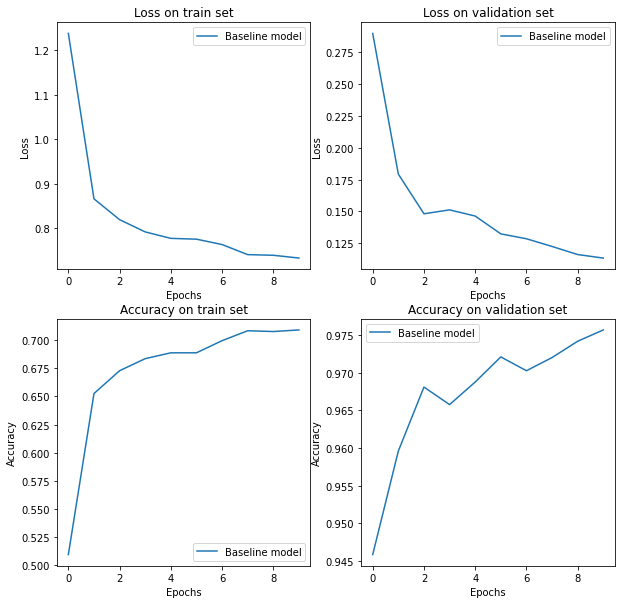

In [ ]:
build_plots(((metrics, f'Baseline model'),))

### Evaluation

#### Baseline accuracy on MNIST test set
**Note: without applying OpenMax algorithm**

In [ ]:
def mnist_test_model(model, loader, osr_mode=False):
    model.osr_enabled = osr_mode
    model.eval()
    correct_lableing = torch.tensor(0)
    batch_sample = next(iter(loader))
    testset_size = len(loader) * len(batch_sample[0])
    with torch.no_grad():
        for data, labels in loader:
            data = preprocessing(data)
            logits, avs = model(data)
            _, preds = torch.max(logits, 1)
            correct_lableing += torch.sum(preds == labels.data)
    return correct_lableing.item() / testset_size

In [ ]:
accuracy = mnist_test_model(model, testset, osr_mode=False)
print(f'Baseline model accuracy on MNIST testset: {accuracy}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Baseline model accuracy on MNIST testset: 0.9742237261146497


#### Confusion Matrix on MNIST test set

In [ ]:
def get_predictions_and_labels(model, loader, osr_mode=False):
    model.osr_enabled = osr_mode
    model.eval()
    preds_accumulator = None
    labels_accumulator = None
    with torch.no_grad():
        for data, labels in loader:
            data = preprocessing(data)
            logits, avs = model(data)
            _, preds = torch.max(logits, 1)
            if labels_accumulator is None:
                labels_accumulator = labels.data
            else: 
                labels_accumulator = torch.cat((labels_accumulator, labels.data))
            if preds_accumulator is None:
                preds_accumulator = preds
            else: 
                preds_accumulator = torch.cat((preds_accumulator, preds))
    return preds_accumulator, labels_accumulator

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


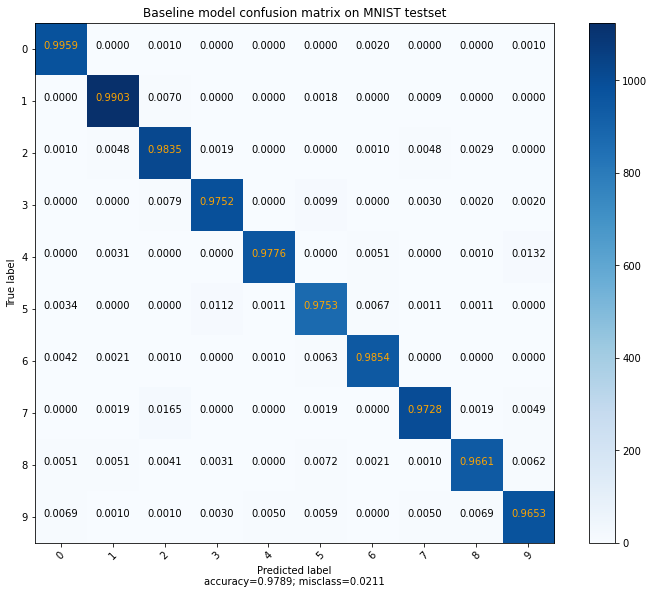

In [ ]:
def plot_confusion_matrix_on_mnist():
    predictions_as_tensor, labels_as_tensor = get_predictions_and_labels(model, testset, osr_mode=False)
    predictions, labels = predictions_as_tensor.numpy(), labels_as_tensor.numpy() 
    conf_mat = confusion_matrix(labels, predictions)
    plot_confusion_matrix(conf_mat, [i for i in range(10)], title='Baseline model confusion matrix on MNIST testset')
plot_confusion_matrix_on_mnist()

## Open Max algorithm training and evaluation

### Training

Open Max method requires pretrained model. I will use the baseline model to fit Weibull distribution for each label, on corrected classified samples.
To ensure that each class gets enough samples, to be trained. 
I use both training set and validataion set to extract the correctly classified samples.
This way for each label we will find the eta most far distances not from 4K sample but from 6K. 

Intuitively I try to expose the algorithm for more samples to fit the algoritm on more data.

Intuitively it should improve the performance because with more data I will cath more "extreme" far distances from labels's mav.

In [ ]:
# Add extra logs to ensure that merging of samples 
# from validation and train sets done successfully
fit_osr(model, debug=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation samples per label
2 size = 1159
0 size = 1205
3 size = 1176
1 size = 1308
8 size = 1143
4 size = 1175
9 size = 1134
7 size = 1218
5 size = 1039
6 size = 1151
Train samples per label
5 size = 4295
7 size = 4947
2 size = 4682
0 size = 4667
1 size = 5356
9 size = 4615
8 size = 4578
6 size = 4690
3 size = 4790
4 size = 4518
Merged samples per label
5 size = 5334
7 size = 6165
2 size = 5841
0 size = 5872
1 size = 6664
9 size = 5749
8 size = 5721
6 size = 5841
3 size = 5966
4 size = 5693


#### Download Open CNN weights, mav and fitted distribution 

In [ ]:
# NOTE
# If you want to load and run this model, you need to load the weights file.
# Then using pickle (a python package) to load the serialized object 
# that contains MAV for each label and fitted Weibull distribution (libMR object) 
def save_open_cnn():
    model_wights_filename = 'open_cnn_weights.pt'
    model_fields_filename = 'open_cnn.fileds.pickle'
    torch.save(model.state_dict(), f'./{model_wights_filename}')
    additional_fields = {
        'alpha': model.alpha,
        'eta': model.eta,
        'class_mav': model.class_mav
    }
    with open(model_fields_filename, 'wb') as handle:
        pickle.dump(additional_fields, handle, protocol=pickle.HIGHEST_PROTOCOL)
    files.download(f'./{model_wights_filename}')
    files.download(f'./{model_fields_filename}')
save_open_cnn()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluation

#### Accuracy on testset after applying Open Max algorithm

In [ ]:
print(f'Accuracy = {mnist_test_model(model, testset, osr_mode=True)}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy = 0.9351114649681529


#### Classification accuracy of OOD set as 'Unknown'

In [ ]:
def ood_test_model(model, loader, test_size):
    model.osr_enabled = True
    model.debug = False
    model.eval()
    correct_lableing = torch.tensor(0)
    with torch.no_grad():
        for data, labels in loader:
              logits, av = model(data)
              _, preds = torch.max(logits, 1)
              correct_lableing += torch.sum(preds == labels.data)
    return correct_lableing.item() / test_size
print(f'Accuracy = {ood_test_model(model, ood_loader, len(ood_dataset))}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy = 0.05


#### Classifion accuracy of OOD as 'Unknown' and MNIST test set as 'Known'

In [ ]:
def get_binary_prediction_if_ood(model, mnist_loader, ood_loader):
    model.osr_enabled = True
    model.debug = False
    model.eval()
    known = 1
    unknown = 0
    preds_accumulator = []
    labels_accumulator = []
    with torch.no_grad():
        for data, labels in mnist_loader:
              labels_accumulator += [known for _ in range(len(labels.data))]
              logits, av = model(data)
              _, preds = torch.max(logits, 1)
              for prediction_of_sample in preds:
                  if prediction_of_sample.item() == OODCifar10.OOD_LABEL:
                    preds_accumulator.append(unknown)
                  else:
                    preds_accumulator.append(known)
        for data, labels in ood_loader:
              labels_accumulator += [unknown for _ in range(len(labels.data))]
              logits, av = model(data)
              _, preds = torch.max(logits, 1)
              for prediction_of_sample in preds:
                  if prediction_of_sample.item() == OODCifar10.OOD_LABEL:
                    preds_accumulator.append(unknown)
                  else:
                    preds_accumulator.append(known)
    return preds_accumulator, labels_accumulator

def open_max_calculate_binary_clf_ood_accuracy(model, mnist_loader, ood_loader):
    predictions, labels = get_binary_prediction_if_ood(model, mnist_loader, ood_loader)
    corrects = sum([pred == label for pred, label in zip(predictions, labels)])
    print(f'Binary classification accuracy of classifing MNIST as "Known" and OOD as "Unknown" is {corrects/ len(labels)}')
open_max_calculate_binary_clf_ood_accuracy(model, testset, ood_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Binary classification accuracy of classifing MNIST as "Known" and OOD as "Unknown" is 0.8779090909090909


#### Confusion matrix of classifing OOD as 'Unknown' and MNIST test set as 'Known'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


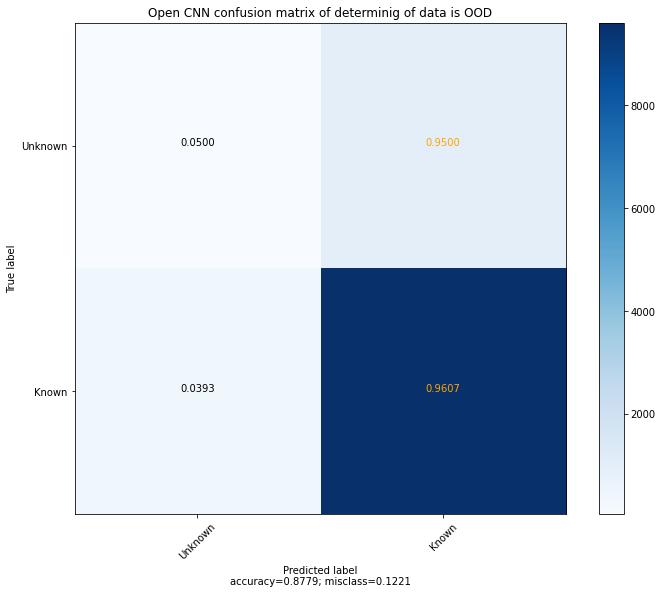

In [ ]:
def open_max_plot_confusion_matrix_of_binary_clf_ood_accuracy(model, mnist_loader, ood_loader):
    predictions, labels = get_binary_prediction_if_ood(model, mnist_loader, ood_loader)
    conf_mat = confusion_matrix(labels, predictions)
    plot_confusion_matrix(conf_mat, ['Unknown', 'Known'], title='Open CNN confusion matrix of determinig of data is OOD')

open_max_plot_confusion_matrix_of_binary_clf_ood_accuracy(model, testset, ood_loader)

#### Total accuracy on 10 MNIST classes and OOD

In [ ]:
def plot_confusion_matrix_on_mnist():
    mnist_predictions_as_tensor, mnist_labels_as_tensor = get_predictions_and_labels(model, testset, osr_mode=True)
    ood_predictions_as_tensor, ood_labels_as_tensor = get_predictions_and_labels(model, ood_loader, osr_mode=True)
    predictions_as_tensor = torch.cat((mnist_predictions_as_tensor, ood_predictions_as_tensor))
    labels_as_tensor = torch.cat((mnist_labels_as_tensor, ood_labels_as_tensor))
    corrects = torch.sum(predictions_as_tensor == labels_as_tensor)
    size = labels_as_tensor.size()[0]
    print(f'Classification accuracy of MNIST and OOD is {corrects/ size}')
plot_confusion_matrix_on_mnist()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Classification accuracy of MNIST and OOD is 0.8584545254707336


#### Confusion matrix of classifing 10 MNIST classes and OOD

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


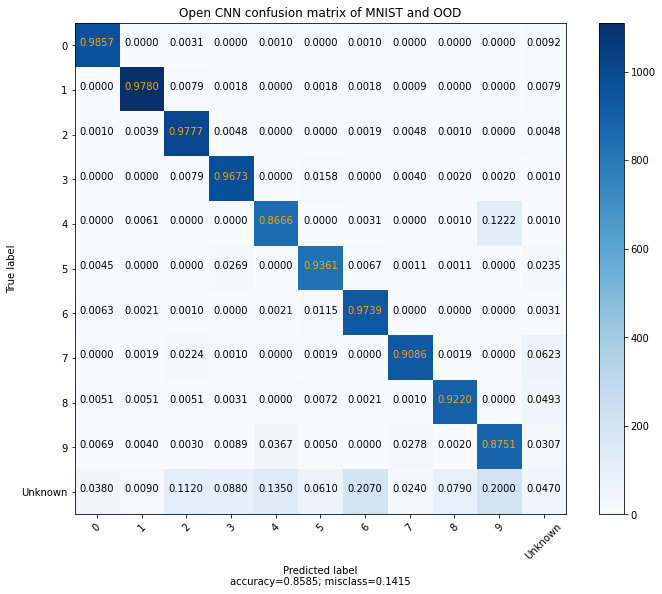

In [ ]:
def plot_confusion_matrix_on_mnist():
    mnist_predictions_as_tensor, mnist_labels_as_tensor = get_predictions_and_labels(model, testset, osr_mode=True)
    ood_predictions_as_tensor, ood_labels_as_tensor = get_predictions_and_labels(model, ood_loader, osr_mode=True)
    predictions_as_tensor = torch.cat((mnist_predictions_as_tensor, ood_predictions_as_tensor))
    labels_as_tensor = torch.cat((mnist_labels_as_tensor, ood_labels_as_tensor))
    predictions, labels = predictions_as_tensor.numpy(), labels_as_tensor.numpy() 
    conf_mat = confusion_matrix(labels, predictions)
    plot_confusion_matrix(conf_mat, [i for i in range(10)] + ['Unknown'], title='Open CNN confusion matrix of MNIST and OOD')
plot_confusion_matrix_on_mnist()

### TSNE Visualization of AV from test and OOD sets

#### Helper functions

In [ ]:
# for each sample from OOD generate av, rearrange as numpy matrix N X 11.
# the av is after applying Open max algorithm
def get_ood_avs(model, loader):
    model.osr_enabled = True
    model.debug = False
    model.eval()
    correct_lableing = torch.tensor(0)
    accumulator = []
    with torch.no_grad():
        for data, labels in loader:
              _, av = model(data)
              accumulator.append(av)
    return torch.vstack(accumulator).numpy()

In [ ]:
# take a subset of samples from each class 
def prepare_avs_4_tsne(subset=1000):
    model.osr_enabled = True
    model.debug = False
    model.eval()
    correct_lableing = torch.tensor(0)
    with torch.no_grad():
        label_avs_map_validation_set = get_corrected_labeled_samples(model, validationset)
        label_avs_map_train_set = get_corrected_labeled_samples(model, trainset)
        label_avs_map = merge_labeled_samples(label_avs_map_train_set, label_avs_map_validation_set)
    samples_per_label_as_matrix = [
                                    (
                                        np.vstack(list(map(lambda av: av.numpy(), label_avs_map[label][:subset]))),
                                        subset,
                                        label
                                    )
                                   for label in label_avs_map
                                  ]
    X = None
    y = np.array([])
    for samples, occurances_times, label in samples_per_label_as_matrix:
        if X is None:
            X = samples
        else:
            X = np.vstack((X, samples))
        y = np.append(y, [label for _ in range(occurances_times)])
    OOD = get_ood_avs(model, ood_loader)
    X = np.vstack((X, OOD))
    y = y.astype(int)
    y = np.append(y, ['unknown' for _ in range(OOD.shape[0])])
    return X, y

#### Applying TSNE

In [ ]:
X, y = prepare_avs_4_tsne(50)
print(f'X shape {X.shape}, Y shape {y.shape}')
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


X shape (1500, 10), Y shape (1500,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.003s...
[t-SNE] Computed neighbors for 1500 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 2.957559


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.788376
[t-SNE] KL divergence after 1000 iterations: 0.709931


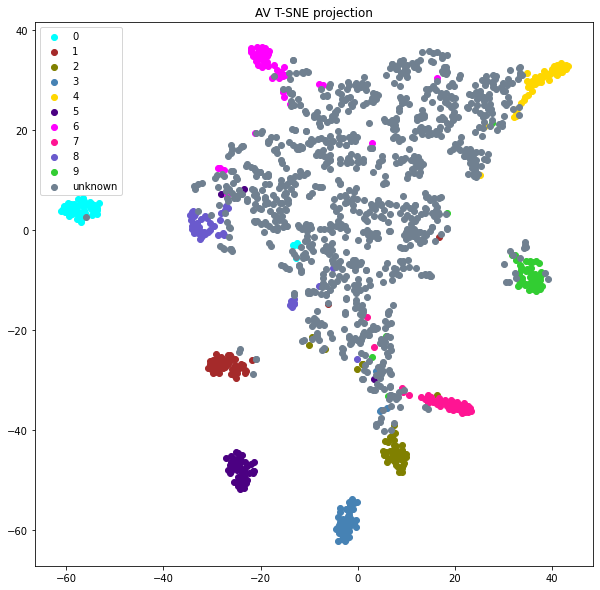

In [ ]:
# create pretty TSNE visualization
def plot_tsne(z, y):
    fig, ax = plt.subplots(1, figsize=(10,10))
    colors = [
        'cyan',
        'brown',
        'olive',
        'steelblue',
        'gold',
        'indigo',
        'fuchsia',
        'deeppink',
        'slateblue',
        'limegreen',
        'slategrey',
    ]
    for label, color_name in zip(np.unique(y), colors):
        ax.scatter(x=z[y == label, 0], y=z[y == label, 1], color = color_name, label=label)
    ax.set_title("AV T-SNE projection")
    ax.legend()
    plt.show()

plot_tsne(z, y)

## Conclusion
As was explained before the Open CNN has model has 2 components:
1. A pre-trained model (or Baseline model)
2. Open Max algorithm that uses the result vector of the last FC layer - simply from "activation vector".

As we can see from the confusion matrix (on the MNIST test set) of **the Baseline model**. The Baseline model had a good accuracy on predicting each class. Same thing on predicting the overall accuracy on the testset.

Moreover, from the TSNE Visualization of resulted avs. Where the avs were generated from feeding the baseline model with samples from OOD and MNIST testset. We can see from TSNE Visualization: 
1. The baseline model mapped MNIST avs to separate "clusters" that are "far" from each other.
2. The OOD avs were spreaded on the gap between the clusters and some outliers of OOD were touching the "edges" of some cluster.

From the above mentioned insights we can say that **the baseline architechture makes a vary good job in separating activation vectors**.

**But**, from the confustion matrix of classifing the OOD data as 'Unknown' and MNIST testset as 'Known'.
Even though the baseline model makes a great job in separating activation vectors of different classes, **the Open Max algorithm performs very poorly** to classify OOD activation vectors as 'Unknown'.
We can see same result in the confusion matrix of classifing OOD as 'Unknown' and classifing all 10 classes of MNIST.

I hypothesise that Open Max algorithm doesn't suit for this kind of data.
Because may be the activation vectors of CIFAR and MNIST are "different" but not "different" enough such that Open Max can catch them.

# Multi Task Autoencoder approach

## Description

Since the CNN architecture that was proposed in  [Open CNN architechture for intrusion detection](https://www.sciencedirect.com/science/article/pii/S1877050920316240) gave desent results. I took the architechture (without the Open Max algorithm) and used it as the Encoder part in my Multi task Auto Encoder.

My Multi Task Autoencoder consists, of encoder:
1. CNN layer with kernel size 5 and 32 output channels.
2. Max pooling layer with kernel size 2. 
3. CNN layer with kernel size 3 and 64 output channels.
4. Max pooling layer with kernel size 2.
5. FC layer of 10 neurons followed by Relu and Dropout of 0.5 to avoid overfitting.
6. FC layer of 10 neurons.

Decoder that takes the last layer of encoder then applies:
1. Relu and Dropout of 0.5. 
2. FC layer of 28*28 neurons, which then reshaped to 1X28X28 image.

Classifier that uses the last layer of the encoder and applies log softmax.

This approach has two training stages:
1. Training Baseline model, the multi task autoencoder.
2. Stage that uses validation set and subset from CIFAR 10 to choose a good reconstruction loss threshold.

I will train the baseline  model, then I will decide a good threshold.

If the model will get a sample that is OOD (like sample from CIFAR 10), the Autoencoder will not succeed to reconstruct the image. The reconstruction loss will be much higher, because the model learned to reconstruct MNIST images.

After choosing a good threshold, the model will take a sample and try to reconstruct it. 
If the reconstruction loss is higher than the threshold, then we will return "unknown" (In code it will be ``None``). 
Otherwise we will return the classifier probability vector, recall that the classifier applies log softmax on the last layer of 10 neurons of the encoder.

#### Multi Task Autoencoder class

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, reconstruction_criterion, clf_criterion) -> None:
        super(Autoencoder, self).__init__()
        self.reconstruction_criterion = reconstruction_criterion
        self.clf_criterion = clf_criterion
        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Flatten(),
                    nn.Linear(64*25, 10),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(10, 10)
                )
        self.decoder = nn.Sequential(
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(10, 28*28),
                    nn.Unflatten(1, (1, 28, 28))
                )
        self.softmax = nn.LogSoftmax(dim=1)
        self.osr_enabled = False
        self.loss_threshold = None
        self.debug = False
        
        
    def forward(self, x):
        encoded_vector = self.encoder(x)
        reconstruction = self.decoder(encoded_vector)
        proba = self.softmax(encoded_vector)
        if self.training:
            return reconstruction, proba
        else:
            if self.osr_enabled:
              loss_per_sample = map(lambda recon, x: torch.nn.functional.mse_loss(recon, x), list(reconstruction), list(x))
              # None - meaning 'unknown'
              return [
                    (reconstruction[i],None) 
                    if self.loss_threshold < loss 
                    else (reconstruction[i], proba[i])
                    for i, loss in enumerate(loss_per_sample)
                  ]
            else:
              return reconstruction, proba

    def batch_train(self, data, optimizer, stage, device=None):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = preprocessing(inputs)
        # mode to device/cuda
        if device is not None:
            inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(stage == 'train'):
            # logits: The raw predictions from the last layer            
            reconstruction, logits = self(inputs)
            _, preds = torch.max(logits, 1)

            # using CE criterion, thus input is the logits
            clf_loss = self.clf_criterion(logits, labels)
            reconstruction_loss = self.reconstruction_criterion(reconstruction, inputs)
            loss = clf_loss + reconstruction_loss
            if stage == 'train':
                loss.backward()
                optimizer.step()
        # statistics
        running_loss = loss.item() * inputs.size(0)
        running_clf_loss = clf_loss.item() * inputs.size(0)
        running_reconstruction_loss = reconstruction_loss.item() * inputs.size(0)
        running_corrects = torch.sum(preds == labels.data)
        return running_loss, running_corrects, running_reconstruction_loss, running_clf_loss
    
    def epoch_train(self, optimizer, trainloader, validationloader, \
        stage, metrics, train_data_size, validation_data_size, device=None):
        epoch_loss = 0
        epoch_accuracy = 0
        if stage == 'train':
            self.train()
            loader = trainloader
        else:
            self.eval()
            loader = validationloader  
        running_loss = 0.0
        running_corrects = 0
        running_reconstruction_loss = 0.0
        running_clf_loss = 0.0
        for i, data in enumerate(loader, 0):
            current_loss, current_corrects, current_reconstruction_loss, current_clf_loss = self.batch_train(data, optimizer, stage, device)
            running_loss += current_loss
            running_corrects += current_corrects
            running_reconstruction_loss += current_reconstruction_loss
            running_clf_loss += current_clf_loss
        dataset_size = 0
        if stage == 'train':
            dataset_size = train_data_size
        else:
            dataset_size = validation_data_size
        epoch_loss = running_loss / dataset_size
        epoch_reconstruction_loss = running_reconstruction_loss / dataset_size
        epoch_clf_loss = running_clf_loss / dataset_size
        epoch_accuracy = running_corrects.double() / dataset_size
        # accuracy is still tensor
        metrics['accuracy'][stage].append(epoch_accuracy.item())
        # loss in python native type number
        metrics['loss'][stage].append(epoch_loss)
        # add reconstruction loss and classification loss for better training statistics feedback
        if not 'reconstruction loss' in metrics:
            metrics['reconstruction loss'] = {}
        if not stage in metrics['reconstruction loss']:
            metrics['reconstruction loss'][stage] = []
        metrics['reconstruction loss'][stage].append(epoch_reconstruction_loss)
        if not 'classification loss' in metrics:
            metrics['classification loss'] = {}
        if not stage in metrics['classification loss']:
            metrics['classification loss'][stage] = []
        metrics['classification loss'][stage].append(epoch_clf_loss)

## Training Baseline model

In [ ]:
ae_model = Autoencoder(reconstruction_criterion= nn.MSELoss(), clf_criterion= nn.NLLLoss())
ae_optimizer = optim.Adam(ae_model.parameters(), lr=0.001)

In [ ]:
metrics = train_model(ae_model, trainset, train_size, validationset, validation_size, \
                      ae_optimizer, epochs_amount=10, device=device)
metrics

Training the model


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 10/10 [01:51<00:00, 11.18s/it]

Finished Training


{'accuracy': {'train': [0.5375,
   0.6253541666666667,
   0.6746041666666667,
   0.6970416666666667,
   0.7025625,
   0.7100208333333333,
   0.7185833333333334,
   0.7215833333333334,
   0.7265833333333334,
   0.72825],
  'validation': [0.951,
   0.9580833333333333,
   0.9705833333333334,
   0.9711666666666666,
   0.9729166666666667,
   0.9748333333333333,
   0.9740833333333333,
   0.9744166666666666,
   0.9749166666666667,
   0.97425]},
 'classification loss': {'train': [1.207343212445577,
   0.9346217154661814,
   0.8045135831038157,
   0.7615585654179255,
   0.73979849811395,
   0.7270505181550979,
   0.7179519242842992,
   0.7097597104708354,
   0.7014324419101079,
   0.7018034938573837],
  'validation': [0.3093738241195679,
   0.19299093401432038,
   0.12060994627078374,
   0.11899712444345156,
   0.10822859065731366,
   0.09434577979147435,
   0.09774517753223579,
   0.09522643026212851,
   0.09475903913378715,
   0.09907686053713163]},
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],


### Baseline training performance 

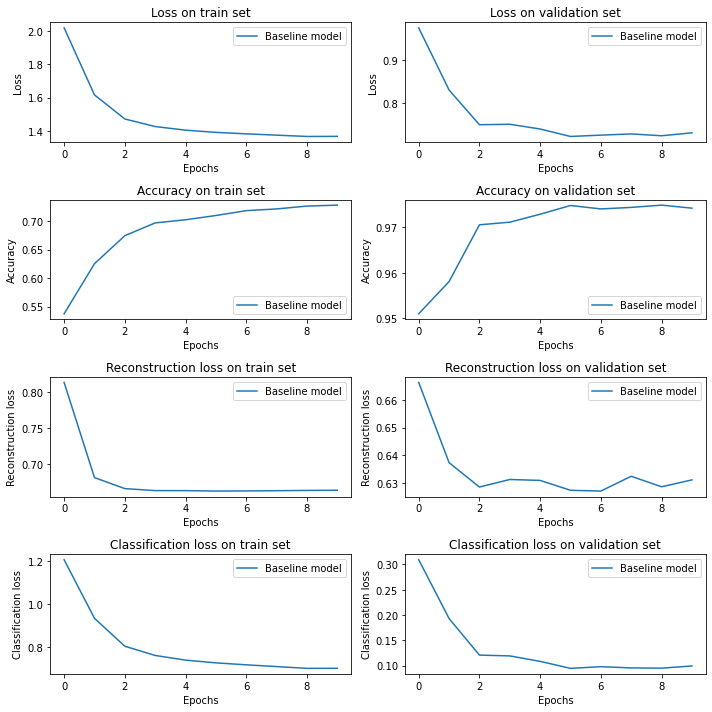

In [ ]:
def show_metric_per_epoch_plot(ax, epochs, y_data_names, \
                               y_label, text, legend_loc="lower right"):
    for y_data, name in y_data_names:
        ax.plot(epochs, y_data, label=name)
    ax.set_title(text)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y_label)
    ax.legend(loc=legend_loc)

def ae_show_metrics(epochs, metrics):
  fig, axs = plt.subplots(4, 2, figsize=(10,10))
  for i, key in enumerate(metrics.keys()):
    train_axs = axs[i][0]
    validation_axs = axs[i][1]
    show_metric_per_epoch_plot(train_axs, epochs, metrics[key]['train'],
                              metrics[key]['desc'], 
                              f"{metrics[key]['desc']} on train set",
                              legend_loc=metrics[key]['loc'])
    show_metric_per_epoch_plot(validation_axs, epochs, metrics[key]['validation'],
                              metrics[key]['desc'], 
                              f"{metrics[key]['desc']} on validation set",
                              legend_loc=metrics[key]['loc'])
  # make more space between subplots
  fig.tight_layout()

# takes list of pairs:
# 1. dictionary object resulted from train_model
# 2. model name as string
# builds plots of loss as function of epoch and accuracy as function of epoch on train and validation sets 
def ae_build_plots(metrics_and_names):
  epochs = metrics_and_names[0][0]['epochs']
  metrics_4_plot = {}
  for metric, name in metrics_and_names:
    for key in metric.keys():
      if key == 'epochs':
        continue
      if not key in metrics_4_plot: 
        metrics_4_plot[key] = {
            'train': [],
            'validation': [],
            'desc': key.capitalize(),
            'loc': "lower right" if key == 'accuracy' else "upper right",
        }
      metrics_4_plot[key]['train'].append((metric[key]['train'], name))
      metrics_4_plot[key]['validation'].append((metric[key]['validation'], name))
  ae_show_metrics(epochs, metrics_4_plot)
  plt.legend()
  plt.show()


ae_build_plots(((metrics, f'Baseline model'),))

### Accuracy of Baseline model classifing MNIST 

In [ ]:
def ae_mnist_test_model(model, loader, osr_mode=False):
    model.osr_enabled = osr_mode
    model.eval()
    correct_lableing = torch.tensor(0)
    batch_sample = next(iter(loader))
    testset_size = len(loader) * len(batch_sample[0])
    with torch.no_grad():
        for data, labels in loader:
            data = preprocessing(data)
            if osr_mode:
                logits = model(data)
                preds = []
                for rec, proba in logits:
                    if proba is None:
                      preds.append(torch.tensor(OODCifar10.OOD_LABEL))
                    else:
                      _, predicted_label = torch.max(proba, dim=0)
                      preds.append(predicted_label)
                preds = list(map(lambda prediction: prediction.unsqueeze(dim=0), preds))
                preds = torch.cat(preds)
            else: 
                _, logits = model(data)
                _, preds = torch.max(logits, 1)
            correct_lableing += torch.sum(preds == labels.data)
    return correct_lableing.item() / testset_size

In [ ]:
print(f'Accuracy on MNIST test set without OSR mode {ae_mnist_test_model(ae_model, testset, osr_mode=False)}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy on MNIST test set without OSR mode 0.96984474522293


### Confusion matrix of Baseline model on MNIST

In [ ]:
def ae_get_labels_and_predictions(model, loader, osr_mode=False):
    model.osr_enabled = osr_mode
    model.eval()
    preds_accumulator = None
    labels_accumulator = None
    with torch.no_grad():
        for data, labels in loader:
            data = preprocessing(data)
            if osr_mode:
                logits = model(data)
                preds = []
                for rec, proba in logits:
                    if proba is None:
                      preds.append(torch.tensor(OODCifar10.OOD_LABEL))
                    else:
                      _, predicted_label = torch.max(proba, dim=0)
                      preds.append(predicted_label)
                preds = list(map(lambda prediction: prediction.unsqueeze(dim=0), preds))
                preds = torch.cat(preds)
            else: 
                _, logits = model(data)
                _, preds = torch.max(logits, 1)
            if labels_accumulator is None:
                labels_accumulator = labels.data
            else: 
                labels_accumulator = torch.cat((labels_accumulator, labels.data))
            if preds_accumulator is None:
                preds_accumulator = preds
            else: 
                preds_accumulator = torch.cat((preds_accumulator, preds))
    return preds_accumulator, labels_accumulator


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


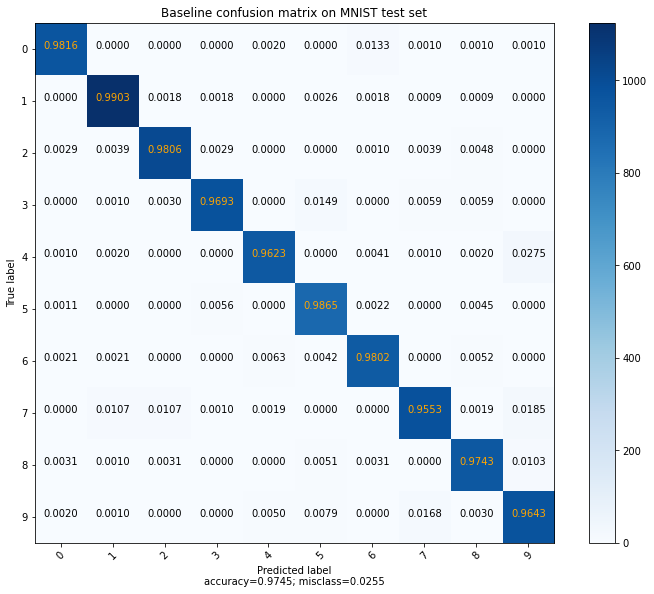

In [ ]:
def plot_confusion_matrix_on_mnist():
    predictions_as_tensor, labels_as_tensor = ae_get_labels_and_predictions(ae_model, testset, osr_mode=False)
    predictions, labels = predictions_as_tensor.numpy(), labels_as_tensor.numpy() 
    conf_mat = confusion_matrix(labels, predictions)
    plot_confusion_matrix(conf_mat, [i for i in range(10)], title='Baseline confusion matrix on MNIST test set')
plot_confusion_matrix_on_mnist()

## Evaluataion of base model

### Box plot of reconstruction loss

We will take a sample from OOD to roughly estimate a good reconstruction threashold.

We will do it by box plotting the validation set reconstruction loss and the OOD reconstruction loss.

In [ ]:
def get_recon_loss_from_samples(model, loader, preprocessing=None):
    model.osr_enabled = False
    model.debug = False
    model.eval()
    loss = []
    with torch.no_grad():
        for data, labels in loader:
              if preprocessing is not None:
                  data = preprocessing(data)
              reconstruction, _  = model(data)
              reconstruction = list(reconstruction)
              data = list(data)
              for src, src_recon in zip(data, reconstruction):
                loss.append(torch.nn.functional.mse_loss(src, src_recon).numpy())
    return np.stack(loss)

In [ ]:
validation_recon_loss = get_recon_loss_from_samples(ae_model, validationset, preprocessing)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
ood_recon_loss = get_recon_loss_from_samples(ae_model, ood_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
validation_size, validation_recon_loss.shape

(12000, (12000,))

In [ ]:
len(ood_dataset), ood_recon_loss.shape

(1000, (1000,))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


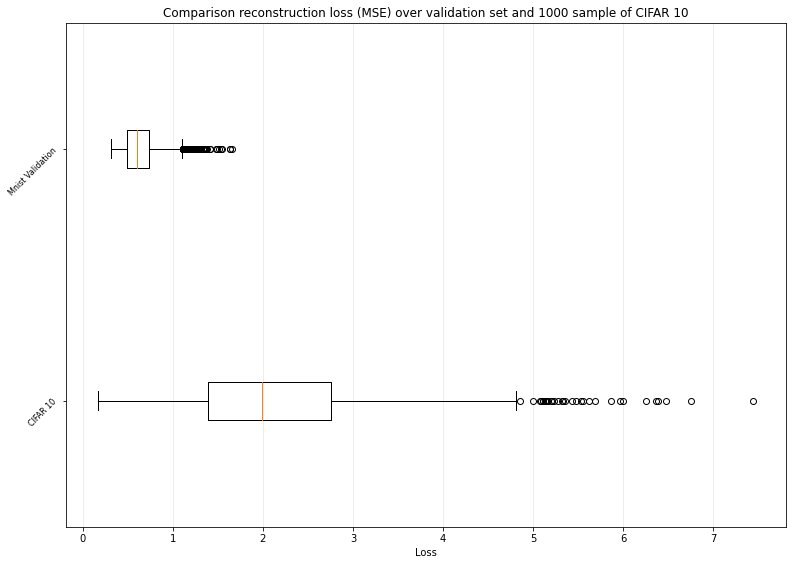

In [ ]:
def show_box_plots_of_loss(data,random_dists):
  fig = plt.figure(figsize =(10, 7))
  # Creating axes instance
  ax = fig.add_axes([0, 0, 1, 1])
  ax.set_yticklabels(random_dists,
                        rotation=45, fontsize=8)
  ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                  alpha=0.5)
  ax.set(
      axisbelow=True,  # Hide the grid behind plot objects
      title='Comparison reconstruction loss (MSE) over validation set and 1000 sample of CIFAR 10',
      xlabel='Loss',
      ylabel='',
  )
  # Creating plot
  box_plot_data = plt.boxplot(data, vert=False)
  # show plot
  plt.show()
  return box_plot_data

data = [ood_recon_loss, validation_recon_loss]
data_names = ['CIFAR 10', 'Mnist Validation']
box_plot_data = show_box_plots_of_loss(data, data_names)

### Evaluation of the plot

In [ ]:
for fliers_name, fliers in zip(data_names, box_plot_data['fliers']):
    print(f'Outliers amount from {fliers_name} box plot {fliers.get_data()[0].shape[0]}') 

Outliers amount from CIFAR 10 box plot 32
Outliers amount from Mnist Validation box plot 196


In [ ]:
whiskers = box_plot_data['whiskers']
box_plot_metrics = {}
for i, name in enumerate(data_names):
    box_plot_metrics[name] = {}
    box_plot_metrics[name]['whisker'] = {}
    box_plot_metrics[name]['quartile'] = {}
    lower_whisker_line = whiskers[i*2].get_xdata()
    higher_whisker_line = whiskers[i*2 + 1].get_xdata()
    # to get the lower 'T' in box plot
    lower_whisker_start = lower_whisker_line[1]
    # to get the higher 'T' in box plot
    higher_whisker_end = higher_whisker_line[1]
    lower_rectangle_edge = lower_whisker_line[0]
    higher_rectangle_edge = higher_whisker_line[0]
    box_plot_metrics[name]['whisker']['lower'] = lower_whisker_start
    box_plot_metrics[name]['whisker']['higher'] = higher_whisker_end
    box_plot_metrics[name]['quartile']['lower'] = lower_rectangle_edge
    box_plot_metrics[name]['quartile']['higher'] = higher_rectangle_edge
    print(f'{name} lower whisker is at {lower_whisker_start}, higher whisker is at {higher_whisker_end}')
    print(f'{name} lower quartile is at {lower_rectangle_edge}, higher quartile is at {higher_rectangle_edge}')
    print()

CIFAR 10 lower whisker is at 0.17362244427204132, higher whisker is at 4.812868595123291
CIFAR 10 lower quartile is at 1.3850898146629333, higher quartile is at 2.7572726011276245

Mnist Validation lower whisker is at 0.3183099329471588, higher whisker is at 1.106977939605713
Mnist Validation lower quartile is at 0.49438194185495377, higher quartile is at 0.7396638840436935



## Choosing the reconstruction loss threshold

Usually each OSR problem contains a business logic. If high FP rate is much more severe outcomes than the TP rate. At this point the decision about the reconstruction loss usually comes from the busssiness logic. 

I assume that our case is the same as in Opem CNN approach our model should detect events of type "low frequency high serverity". In such case I will prefer to reduce the accuracy on MNIST but to catch outliers, i.e. samples that are OOD.

From the box plot we can see that in the MNIST case:
1. 50% (the box boundries) of the samples' reconstruction loss is tightly concentrated around the median.
2. 25% (the higher whisker) of the samples is close to the box
3. There are many outliers (dots that overflow the right whisker).

In the CIFAR 10 case:
1. The median and 50% (box boundries) of the samples are **much** higher than the higher whisker of MNIST. 
2. 25% (the higher whisker) of the samples have even more large reconstruction loss. Same thing about the right most CIFAR 10 outliers. 

In the light of the above, if we chose the reconstruction threashold to be on the highest whisker of MNIST. We will catch a big part of MNIST reconstruction range and reject most of OOD samples. Because the MNIST highest whisker doesn't ovelap with the box boundries of CIFAR 10, hence from the plot we will catch 75% and even more from CIFAR 10 samples as 'Unknown'.

In [ ]:
ae_model.loss_threshold = torch.tensor(box_plot_metrics['Mnist Validation']['whisker']['higher'])

### Download Autoencoder weights

In [ ]:
# NOTE
# If you want to load and run this model, you need to load the weights file.
# Then using pickle (a python package) to load the serialized object 
# that contains the reconstruction loss threshold
def save_ae():
    model_wights_filename = 'ae_weights.pt'
    model_fields_filename = 'autoencoder.fileds.pickle'
    torch.save(ae_model.state_dict(), f'./{model_wights_filename}')
    additional_fields = {
        'loss_threshold': ae_model.loss_threshold
    }
    with open(model_fields_filename, 'wb') as handle:
        pickle.dump(additional_fields, handle, protocol=pickle.HIGHEST_PROTOCOL)
    files.download(f'./{model_wights_filename}')
    files.download(f'./{model_fields_filename}')
save_ae()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation on OSR

### Accuracy of classification of OOD as 'Unknown' 

#### Accuracy on same subset used to choose the threshold

In [ ]:
def ood_test_model(model, loader, test_size):
    model.osr_enabled = True
    model.debug = False
    model.eval()
    correct_lableing = torch.tensor(0)
    with torch.no_grad():
        for data, labels in loader:
              logits = model(data)
              preds = []
              for rec, proba in logits:
                  if proba is None:
                    preds.append(torch.tensor(OODCifar10.OOD_LABEL))
                  else:
                    _, predicted_label = torch.max(proba, dim=0)
                    preds.append(predicted_label)
              preds = list(map(lambda prediction: prediction.unsqueeze(dim=0), preds))
              preds = torch.cat(preds)
              correct_lableing += torch.sum(preds == labels.data)
    return correct_lableing.item() / test_size
print(f'Accuracy = {ood_test_model(ae_model, ood_loader, len(ood_dataset))}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy = 0.843


#### Accuracy on different subset from CIFAR 10

In [ ]:
another_ood_dataset = OODCifar10(1000, cifar_preprocessing)
another_ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=4, shuffle=False, num_workers=4) 

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(f'Accuracy = {ood_test_model(ae_model, another_ood_loader, len(ood_dataset))}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy = 0.843


### Accuracy of classification of MNIST 10 classes with thresholding

In [ ]:
print(f'Accuracy on MNIST test set with OSR mode {ae_mnist_test_model(ae_model, testset, osr_mode=True)}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy on MNIST test set with OSR mode 0.9546178343949044


### Classification accuracy of OOD as 'Unknown' and MNIST test set as 'Known'

In [ ]:
def ae_get_binary_prediction_if_ood(model, mnist_loader, ood_loader):
    model.osr_enabled = True
    model.debug = False
    model.eval()
    known = 1
    unknown = 0
    preds_accumulator = []
    labels_accumulator = []
    with torch.no_grad():
        for data, labels in mnist_loader:
              labels_accumulator += [known for _ in range(len(labels.data))]
              logits = model(data)
              for rec, proba in logits:
                  if proba is None:
                    preds_accumulator.append(unknown)
                  else:
                    preds_accumulator.append(known)
        for data, labels in ood_loader:
              labels_accumulator += [unknown for _ in range(len(labels.data))]
              logits = model(data)
              for rec, proba in logits:
                  if proba is None:
                    preds_accumulator.append(unknown)
                  else:
                    preds_accumulator.append(known)
    return preds_accumulator, labels_accumulator

def calculate_binary_clf_ood_accuracy(ae_model, mnist_loader, ood_loader):
    predictions, labels = ae_get_binary_prediction_if_ood(ae_model, mnist_loader, ood_loader)
    corrects = sum([pred == label for pred, label in zip(predictions, labels)])
    print(f'Binary classification accuracy of classifing MNIST as "Known" and OOD as "Unknown" is {corrects/ len(labels)}')
calculate_binary_clf_ood_accuracy(ae_model, testset, another_ood_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Binary classification accuracy of classifing MNIST as "Known" and OOD as "Unknown" is 0.9857272727272727


### Confusion matrix of classifing OOD as 'Unknown' and MNIST test set as 'Known'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


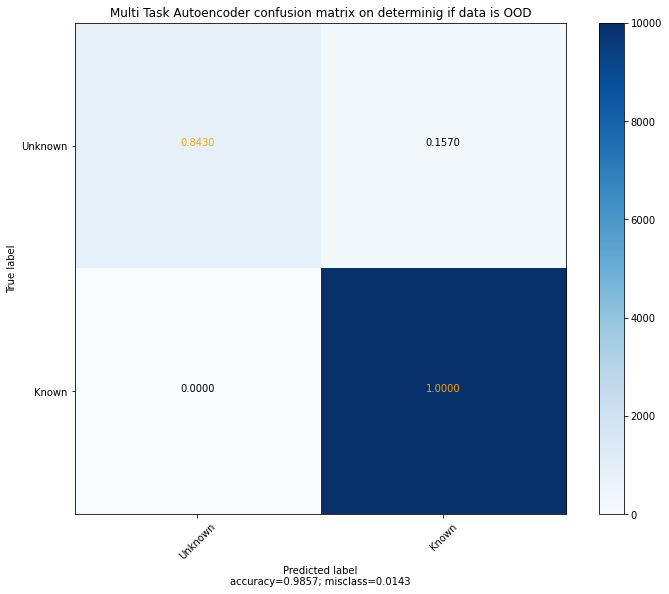

In [ ]:
def plot_confusion_matrix_of_binary_clf_ood_accuracy(model, mnist_loader, ood_loader):
    predictions, labels = ae_get_binary_prediction_if_ood(ae_model, mnist_loader, ood_loader)
    conf_mat = confusion_matrix(labels, predictions)
    plot_confusion_matrix(conf_mat, ['Unknown', 'Known'], title='Multi Task Autoencoder confusion matrix on determinig if data is OOD')

plot_confusion_matrix_of_binary_clf_ood_accuracy(ae_model, testset, another_ood_loader)

### Total accuracy on 10 MNIST classes and OOD

In [ ]:
def calculate_accuracy_on_mnist_and_OOD():
    mnist_predictions_as_tensor, mnist_labels_as_tensor = ae_get_labels_and_predictions(ae_model, testset, osr_mode=True)
    ood_predictions_as_tensor, ood_labels_as_tensor = ae_get_labels_and_predictions(ae_model, another_ood_loader, osr_mode=True)
    predictions_as_tensor = torch.cat((mnist_predictions_as_tensor, ood_predictions_as_tensor))
    labels_as_tensor = torch.cat((mnist_labels_as_tensor, ood_labels_as_tensor))
    corrects = torch.sum(predictions_as_tensor == labels_as_tensor)
    size = labels_as_tensor.size()[0]
    print(f'Classification accuracy of MNIST and OOD is {corrects/ size}')
calculate_accuracy_on_mnist_and_OOD()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Classification accuracy of MNIST and OOD is 0.9627272486686707


### Confusion matrix of classifing 10 MNIST classes and OOD

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


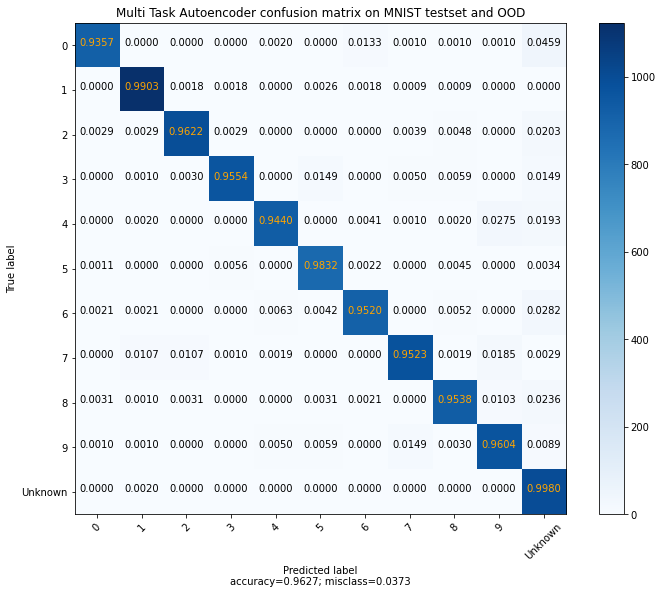

In [ ]:
def plot_confusion_matrix_on_mnist_and_OOD():
    mnist_predictions_as_tensor, mnist_labels_as_tensor = ae_get_labels_and_predictions(ae_model, testset, osr_mode=True)
    ood_predictions_as_tensor, ood_labels_as_tensor = ae_get_labels_and_predictions(ae_model, another_ood_loader, osr_mode=True)
    predictions_as_tensor = torch.cat((mnist_predictions_as_tensor, ood_predictions_as_tensor))
    labels_as_tensor = torch.cat((mnist_labels_as_tensor, ood_labels_as_tensor))
    predictions, labels = predictions_as_tensor.numpy(), labels_as_tensor.numpy() 
    conf_mat = confusion_matrix(labels, predictions)
    plot_confusion_matrix(conf_mat, [i for i in range(10)] + ['Unknown'], title='Multi Task Autoencoder confusion matrix on MNIST testset and OOD')
plot_confusion_matrix_on_mnist_and_OOD()

# Discussion about how Multi Task Autoencoder will make future predictions on different OOD data

I think that datasets that are much more different from MNIST (Like dataset of biological cell images) will have very large reconstruction loss. In such case the accuracy of classifing OOD as 'Unknown' will be higher. Becuase the samples of the dataset will have very large reconstruction loss and will be rejected by the reconstruction loss threashold test, i.e. marked as 'Unknown'.

On other hand datasets that are more similar to MNIST (Like dataset of hand written alphabet) will have large reconstruction loss, but not that high as reconstruction loss of cell images. 
Hence in that case the accuracy of classifing OOD as 'Unknown' will high but relatively low to dataset of cell images. 
Because, outliers in alphabet dataset that are similar to digits of MNIST will have low reconstruction loss and then will be accepted by the reconstruction loss threshold test. I.e. will be considered as sample from MNIST and will get a 10 length probability vector of MNIST classes.

How testing on different OOD data will affect classifing MNIST dataset samples? 

There will be no affect. As we see from the box plot, images from MNIST will have very low reconstruction loss. Thus they will be accepted by the reconstruction loss test. We got very good results in confusion matrix of classifing OOD data and MNIST 10 classes, meaning that even after applying threshold on recostruction loss we still got good result of classifing MNIST. More over we used the Open CNN neural network architecture (without Open Max algorithm). Which also got good results as baseline model for classifing MNIST dataset.